In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import os
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

In [ ]:
 !pip install opendatasets

In [ ]:

import opendatasets as od
od.download("https://www.kaggle.com/datasets/vbookshelf/pneumothorax-chest-xray-images-and-masks/data")

Skipping, found downloaded files in "./pneumothorax-chest-xray-images-and-masks" (use force=True to force download)


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
device = torch.device("cpu")
print(f"Using device: {device}")


Using device: cpu


In [ ]:
import multiprocessing
multiprocessing.cpu_count()

2

In [ ]:
class PneumoniaDataset(data.Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.csv_file = csv_file
        self.transform = transform
        self.data_info = pd.read_csv(csv_file)

    def __getitem__(self, index):
        image_id = self.data_info.iloc[index, 0]
        label = self.data_info.iloc[index, 2]
        image_path = os.path.join(self.root_dir, 'png_images', f'{image_id}')

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.data_info)

In [ ]:
# Example usage:
root_dir = '/content/pneumothorax-chest-xray-images-and-masks/siim-acr-pneumothorax'
train_csv_file = '/content/pneumothorax-chest-xray-images-and-masks/siim-acr-pneumothorax/stage_1_train_images.csv'
test_csv_file = '/content/pneumothorax-chest-xray-images-and-masks/siim-acr-pneumothorax/stage_1_test_images.csv'
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

train_dataset = PneumoniaDataset(root_dir, train_csv_file, transform)
test_dataset = PneumoniaDataset(root_dir, test_csv_file, transform)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset)*0.8), len(train_dataset)-int(len(train_dataset)*0.8)])
# train_labels = np.array(train_dataset.dataset.labels)[train_dataset.indices].tolist()
# test_labels = test_dataset.labels
# val_labels = np.array(train_dataset.dataset.labels)[val_dataset.indices].tolist()

In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

8540
2135
1372


In [ ]:
# from collections import Counter
# print(Counter(train_labels))

In [ ]:
# Get the labels for the train and test datasets
train_labels = []
test_labels = []
val_labels = []

for i in range(len(train_dataset)):
    train_label = train_dataset[i][1]
    train_labels.append(train_label)
    print(f"Train dataset iteration: i = {i}")

for i in range(len(test_dataset)):
    test_label = test_dataset[i][1]
    test_labels.append(test_label)
    print(f"Test dataset iteration: i = {i}")

for i in range(len(val_dataset)):
    val_label = val_dataset[i][1]
    val_labels.append(val_label)
    print(f"Validation dataset iteration: i = {i}")

Streaming output truncated to the last 5000 lines.
Train dataset iteration: i = 7047
Train dataset iteration: i = 7048
Train dataset iteration: i = 7049
Train dataset iteration: i = 7050
Train dataset iteration: i = 7051
Train dataset iteration: i = 7052
Train dataset iteration: i = 7053
Train dataset iteration: i = 7054
Train dataset iteration: i = 7055
Train dataset iteration: i = 7056
Train dataset iteration: i = 7057
Train dataset iteration: i = 7058
Train dataset iteration: i = 7059
Train dataset iteration: i = 7060
Train dataset iteration: i = 7061
Train dataset iteration: i = 7062
Train dataset iteration: i = 7063
Train dataset iteration: i = 7064
Train dataset iteration: i = 7065
Train dataset iteration: i = 7066
Train dataset iteration: i = 7067
Train dataset iteration: i = 7068
Train dataset iteration: i = 7069
Train dataset iteration: i = 7070
Train dataset iteration: i = 7071
Train dataset iteration: i = 7072
Train dataset iteration: i = 7073
Train dataset iteration: i = 70

In [ ]:
# Perform stratified split on the train_dataset
train_dataset, _ = train_test_split(
    train_dataset,
    test_size=0.6,
    stratify=train_labels,
    random_state=42
)

# Perform stratified split on the test_dataset
test_dataset, _ = train_test_split(
    test_dataset,
    test_size=0.6,
    stratify=test_labels,
    random_state=42
)

# Perform stratified split on the val_dataset
val_dataset, _ = train_test_split(
    val_dataset,
    test_size=0.6,
    stratify=val_labels,
    random_state=42
)

In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

3416
854
548


In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=multiprocessing.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=multiprocessing.cpu_count())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=multiprocessing.cpu_count())

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model = torchvision.models.densenet121(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = True
        self.fc = nn.Linear(self.model.classifier.in_features, 1)

        self.model.classifier = self.fc

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model = MyModel().to(device)

# Defining loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
for epoch in range(10):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_train_preds = []
    all_train_labels = []
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()  # Threshold the output to get binary predictions
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())
    torch.save(model.state_dict(), f'model_weights_epoch_{epoch+1}.pth')

    with torch.no_grad():
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_val_preds = []
        all_val_labels = []
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = (outputs > 0.5).float()  # Threshold the output to get binary predictions
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            all_val_preds.extend(predicted.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())
        print('Epoch %d, Loss: %.3f, Train Acc: %.3f, Val Acc: %.3f, Val Loss: %.3f' %
              (epoch+1, running_loss/(i+1), correct_train/total_train, correct_val/total_val, val_loss/(i+1)))

print('Finished Training')

In [ ]:
results = []
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(inputs)):
            prob = probabilities[i][1].item()  # Probability of the positive class
            ground_truth = labels[i].item()
            label_str = predicted[i].item()
            results.append([prob, ground_truth, label_str])

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8321


In [ ]:
results_df = pd.DataFrame(results, columns = ['prob', 'ground_truth', 'label'])
results_df.to_csv('/content/pneumothorax-chest-xray-images-and-masks/siim-acr-pneumothorax/results.csv', index=False)

print('Testing and saving results completed.')

Testing and saving results completed.


In [ ]:
# Calculate additional metrics after training is finished
from sklearn.metrics import confusion_matrix, roc_curve, auc
train_tn, train_fp, train_fn, train_tp = confusion_matrix(all_train_labels, all_train_preds).ravel()
val_tn, val_fp, val_fn, val_tp = confusion_matrix(all_val_labels, all_val_preds).ravel()

train_sensitivity = train_tp / (train_tp + train_fn)
train_specificity = train_tn / (train_tn + train_fp)
train_precision = train_tp / (train_tp + train_fp)

val_sensitivity = val_tp / (val_tp + val_fn)
val_specificity = val_tn / (val_tn + val_fp)
val_precision = val_tp / (val_tp + val_fp)

fpr, tpr, _ = roc_curve(all_val_labels, all_val_preds)
val_auroc = auc(fpr, tpr)

print(f'Train Sensitivity: {train_sensitivity:.3f}, Train Specificity: {train_specificity:.3f}, Train Precision: {train_precision:.3f}')
print(f'Val Sensitivity: {val_sensitivity:.3f}, Val Specificity: {val_specificity:.3f}, Val Precision: {val_precision:.3f}')
print(f'Val AUROC: {val_auroc:.3f}')

Train Sensitivity: 0.698, Train Specificity: 0.938, Train Precision: 0.763
Val Sensitivity: 0.464, Val Specificity: 0.929, Val Precision: 0.659
Val AUROC: 0.696


In [ ]:
# max prob vs single gt(2 class)
y_pred = [result[2] for result in results]
y_true = [result[1] for result in results]
# y_prob = [result[0] for result in results]
# Convert y_pred to a NumPy array
y_pred_array = np.array(y_pred)
# Now you can use argmax
y_pred_class = np.argmax(y_pred_array)
# Compare predicted class indices with ground truth
correct_predictions = (y_pred_class == y_true)
# Calculate accuracy
accuracy = np.mean(correct_predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.21


In [ ]:
#

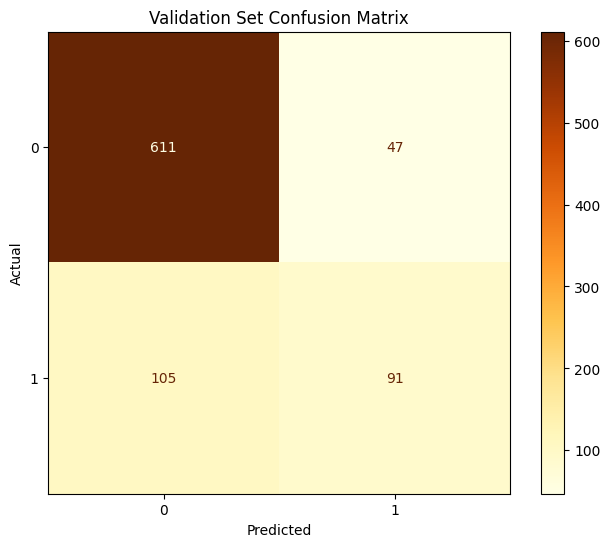

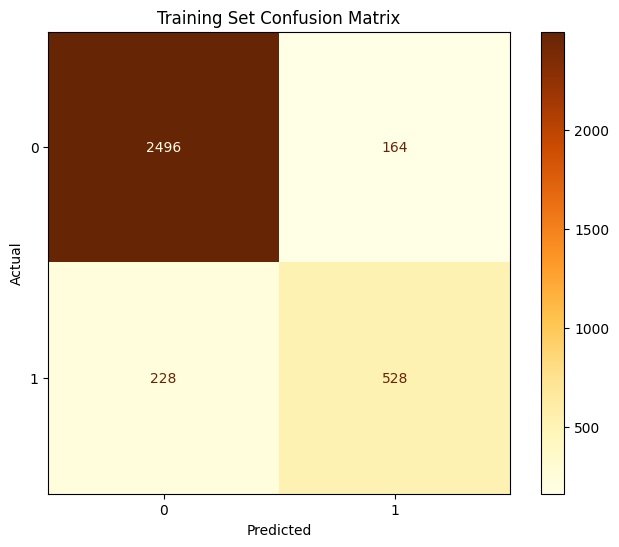

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have the following variables:
# y_true_val, y_pred_val (for the validation set)
# y_true_train, y_pred_train (for the training set)

# Validation set confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm_val = confusion_matrix(all_val_labels, all_val_preds)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot(ax=ax, cmap='YlOrBr')
plt.title('Validation Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Training set confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm_train = confusion_matrix(all_train_labels, all_train_preds)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot(ax=ax, cmap='YlOrBr')
plt.title('Training Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()